In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Assignment

/content/drive/MyDrive/Assignment


Khai báo các thư viện

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Đọc dữ liệu

In [4]:
df = pd.read_csv('train.csv')
df = df.drop(['Id'], axis=1)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,

Tiền xử lý

In [5]:
# Xử lý các giá trị bị thiếu
df = df.fillna(0)

In [6]:
# Nhị phân hóa các giá trị rời rạc
df = pd.get_dummies(df)

X = df.drop(['SalePrice'], axis=1)
y = df['SalePrice']

Chọn thuộc tính

In [7]:
# Loại bỏ các thuộc tính low variance
sel = VarianceThreshold(threshold=(.90 * (1 - .90)))
X_new = sel.fit_transform(X)
X = X[X.columns[sel.get_support(indices=True)]]

In [8]:
# Chọn các thuộc tính tương quan nhất với output
sel = SelectKBest(f_regression, k=25)
X_new = sel.fit_transform(X, y)
X = X[X.columns[sel.get_support(indices=True)]]

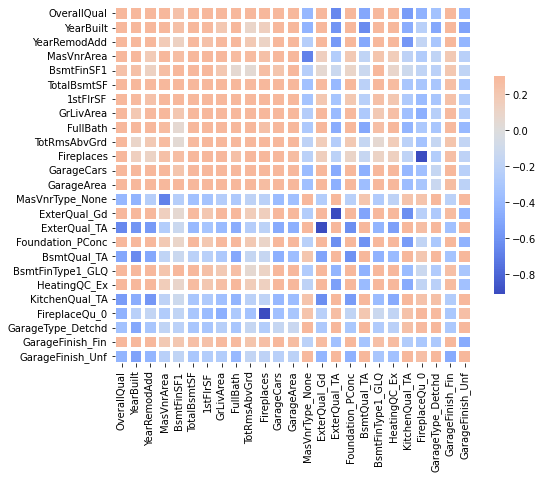

In [9]:
# Visualize độ tương quan giữa các thuộc tính
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(X.corr(), cmap="coolwarm", vmax=.3, center=0, square=True, linewidths=2.5, 
            cbar_kws={"shrink": .5}, annot=False, fmt="1.1f")

In [10]:
# Loại bỏ các thuộc tính tương quan, phụ thuộc vào các thuộc tính khác
X = X.drop(['MasVnrType_None', 'ExterQual_TA', 'BsmtQual_TA', 'KitchenQual_TA', 'FireplaceQu_0'], axis=1)

In [11]:
X.columns

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'ExterQual_Gd',
       'Foundation_PConc', 'BsmtFinType1_GLQ', 'HeatingQC_Ex',
       'GarageType_Detchd', 'GarageFinish_Fin', 'GarageFinish_Unf'],
      dtype='object')

Chuẩn hóa giá trị các thuộc tính

In [12]:
X = np.log(1+X)
X.describe()

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,ExterQual_Gd,Foundation_PConc,BsmtFinType1_GLQ,HeatingQC_Ex,GarageType_Detchd,GarageFinish_Fin,GarageFinish_Unf
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,1.940309,7.586821,7.593756,2.120264,4.229731,6.750560,7.008452,7.268512,0.917827,1.994407,0.399875,0.972599,5.808156,0.231682,0.307169,0.198449,0.351796,0.183731,0.167115,0.287229
std,0.201983,0.015389,0.010424,2.628759,2.992052,1.145712,0.317431,0.333303,0.223281,0.214246,0.394660,0.322269,1.455118,0.327088,0.344444,0.313432,0.346653,0.306039,0.296594,0.341572
min,0.693147,7.535297,7.576097,0.000000,0.000000,0.000000,5.814131,5.814131,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.791759,7.578145,7.584773,0.000000,0.000000,6.680541,6.783325,7.030415,0.693147,1.791759,0.000000,0.693147,5.815592,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.945910,7.587817,7.598399,0.000000,5.951943,6.900227,6.992096,7.289611,1.098612,1.945910,0.693147,1.098612,6.175867,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000
75%,2.079442,7.601402,7.603399,5.107456,6.569832,7.169542,7.238676,7.483104,1.098612,2.079442,0.693147,1.098612,6.357842,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147
max,2.397895,7.606387,7.606387,7.378384,8.638525,8.717846,8.453827,8.638171,1.386294,2.708050,1.386294,1.609438,7.257708,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147


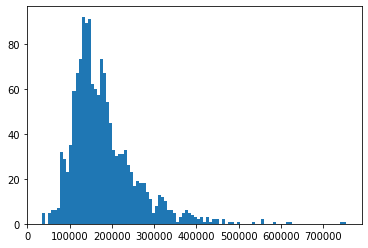

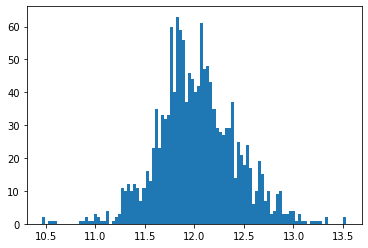

In [13]:
plt.hist(y, bins=100)
plt.show()
y = np.log(1+y)
plt.hist(y, bins=100)
plt.show()

Chia dữ liệu

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape[0]

1095

Huấn luyện mô hình

In [15]:
# Mạng neural 1 tầng ẩn với 10 neural
model = Sequential()
model.add(Dense(10, input_dim=20, activation='relu'))
model.add(Dense(1, activation='relu'))

# Các siêu tham số
adam_optimizer = keras.optimizers.Adam(learning_rate=0.001)
batch_size = 64
epochs = 2000

# Hàm loss mse
model.compile(loss='mse', optimizer=adam_optimizer, metrics=[keras.metrics.RootMeanSquaredError()])

# Cài đặt tham số để lưu model tốt nhất với validation loss
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Lưu quá trình training
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[best_model], shuffle=True)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Epoch 751/2000
18/18 [==============================] - 0s 8ms/step - loss: 0.0271 - root_mean_squared_error: 0.1647 - val_loss: 0.0234 - val_root_mean_squared_error: 0.1529

Epoch 00751: val_loss improved from 0.02341 to 0.02339, saving model to best_model.h5
Epoch 752/2000
18/18 [==============================] - 0s 6ms/step - loss: 0.0264 - root_mean_squared_error: 0.1624 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1532

Epoch 00752: val_loss did not improve from 0.02339
Epoch 753/2000
18/18 [==============================] - 0s 6ms/step - loss: 0.0264 - root_mean_squared_error: 0.1625 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1555

Epoch 00753: val_loss did not improve from 0.02339
Epoch 754/2000
18/18 [==============================] - 0s 7ms/step - loss: 0.0267 - root_mean_squared_error: 0.1634 - val_loss: 0.0238 - val_root_mean_squared_error: 0.1541

Epoch 00754: val_loss did not improve from 0.02339
Epoc

Quá trình huấn luyện

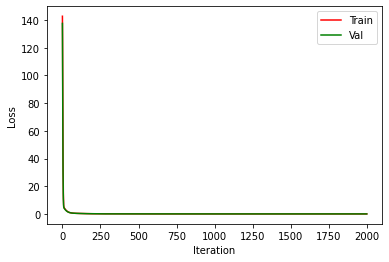

In [16]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

iters = np.arange(0, epochs)
plt.plot(iters, train_loss, 'r-', label='Train')
plt.plot(iters, val_loss, 'g-', label='Val')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

Tạo file kết quả cho dữ liệu Test

In [17]:
df_test = pd.read_csv('test.csv')
df_test = df_test.drop(['Id'], axis=1)
df_test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GL

In [18]:
df_test = df_test.fillna(0)
df_test = pd.get_dummies(df_test)

In [19]:
X_test = df_test[X.columns]
X_test = np.log(1+X_test)

In [20]:
model = keras.models.load_model(filepath='best_model.h5')

y_test = model.predict(X_test)

y_test = np.exp(y_test)-1

res = np.concatenate(([range(1461, 2920)], y_test.T))

columns = ['Id', 'SalePrice']

res = pd.DataFrame(data=res.T, columns=columns)
res['Id'] = res['Id'].astype('int')

res.to_csv('submission.csv', index=False)